# Anomaly Detection on MRI scans of Brain Tumors
- Apply Unsupervised Learning approaches to distinguish MRI scans of "normal" brains from those with tumors.
- PCA: Find a new 2-dimensional space of images to compare to original MRI scans. Individual large numerical differences between images in the PCA space and those in the original space indicate anomalous data.
- These differences are measured by Mean Squared Error.
- To bolster numerical efficiency and preprocess images before performing PCA, we construct low-dimensional representations of the images via Randomized SVD.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cv2
from numpy.linalg import svd
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import PCA, NMF

import time
import torch

In [2]:
train_path = "./MRIscans/Training"
test_path = "./MRIscans/Testing"
val_path = "./MRIscans/Validation"
pca_path = "./MRIscans/PCAdataset"

In [3]:
def load_images(data_path, data_set_type: str):
    train_no_tumor = []
    test_no_tumor, test_tumor = [], []
    test_no_tumor_and_labels, test_tumor_and_labels = [], []
    val_images = []
    
    pca_tumor, pca_no_tumor = [], []
    
    
    if data_set_type == "train":
        
        for f in os.listdir(data_path):
            if f != '.DS_Store' and f == 'no_tumor_train':
                path = os.path.join(data_path+'/', f)
                for img in os.listdir(path):
                    if img.endswith(".jpeg") or img.endswith(".jpg") or img.endswith(".JPEG"):
                        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                        # Resize images to all have same dimensions -> avoid large image data problems
                        new_img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = new_img_array.astype(float, copy=False)/255  
                        train_no_tumor.append(new_img_array)
            
                        
    elif data_set_type == "test":
        for f in os.listdir(data_path):
            if f != '.DS_Store' and f == 'no_tumor':
                test_no_tumor_path = os.path.join(data_path+'/', f)
                for img in os.listdir(test_no_tumor_path):
                    if img.endswith(".jpeg") or img.endswith(".jpg") or img.endswith(".JPEG"):
                        img_array = cv2.imread(os.path.join(test_no_tumor_path, img), cv2.IMREAD_GRAYSCALE)
                        img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = img_array.astype(float, copy=False)/255 
                        
                        # Here we create a list of tuples of the images along with their respective label.
                        # 1 = no_tumor (the anomaly). 0 = tumor (non-anomalous data)
                        test_no_tumor.append(new_img_array)
                        class_1 = np.ones(len(test_no_tumor))
                        test_no_tumor_and_labels = [test_no_tumor, class_1.tolist()]
                        
            
            if f == "tumor_test":
                test_tumor_path = os.path.join(data_path+'/', f)
                for img in os.listdir(test_tumor_path):
                    if img.endswith(".jpeg") or img.endswith(".jpg") or img.endswith(".JPEG"):
                        img_array = cv2.imread(os.path.join(test_tumor_path, img), cv2.IMREAD_GRAYSCALE)
                        img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = img_array.astype(float, copy=False)/255  
                        test_tumor.append(new_img_array)
                        class_0 = np.zeros(len(test_tumor))
                        test_tumor_and_labels = [test_tumor, class_0.tolist()]
                        
    elif data_set_type == "PCAdataset":
        for f in os.listdir(data_path):
            if f != '.DS_Store' and f == 'no_tumor':
                test_no_tumor_path = os.path.join(data_path+'/', f)
                for img in os.listdir(test_no_tumor_path):
                    if img.endswith(".jpeg") or img.endswith(".jpg") or img.endswith(".JPEG"):
                        img_array = cv2.imread(os.path.join(test_no_tumor_path, img), cv2.IMREAD_GRAYSCALE)
                        img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = img_array.astype(float, copy=False)/255 
                        
                        pca_no_tumor.append(new_img_array)
                        
            elif f != '.DS_Store' and f == 'tumor':
                test_no_tumor_path = os.path.join(data_path+'/', f)
                for img in os.listdir(test_no_tumor_path):
                    if img.endswith(".jpeg") or img.endswith(".jpg") or img.endswith(".JPEG"):
                        img_array = cv2.imread(os.path.join(test_no_tumor_path, img), cv2.IMREAD_GRAYSCALE)
                        img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = img_array.astype(float, copy=False)/255 
                        
                        pca_tumor.append(new_img_array)
            else:
                None
    
                
    else:
        for f in os.listdir(data_path):
            if f != '.DS_Store':
                validation_path = os.path.join(data_path+'/', f)
                try:
                    for img in os.listdir(os.path.abspath(validation_path)):
                        
                        if img.endswith(".jpeg") or img.endswith(".jpg") or img.endswith(".JPEG"):
                            img_array = cv2.imread(os.path.join(validation_path, img), cv2.IMREAD_GRAYSCALE)
                            new_img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                            # normalize pixel values to be between 0 and 1
                            new_img_array = new_img_array.astype(float, copy=False)/255  
                            val_images.append(new_img_array)
                except Exception as e:
                    raise e

                    
    return train_no_tumor, test_no_tumor_and_labels, test_tumor_and_labels, val_images, pca_tumor, pca_no_tumor

In [4]:
train_no_t, _,_,_,_,_ = load_images(train_path, 'train')


_, test_no_labels, test_yes_labels, _,_,_ = load_images(test_path, 'test')

Number of training samples: 1835; Number of test samples: 867


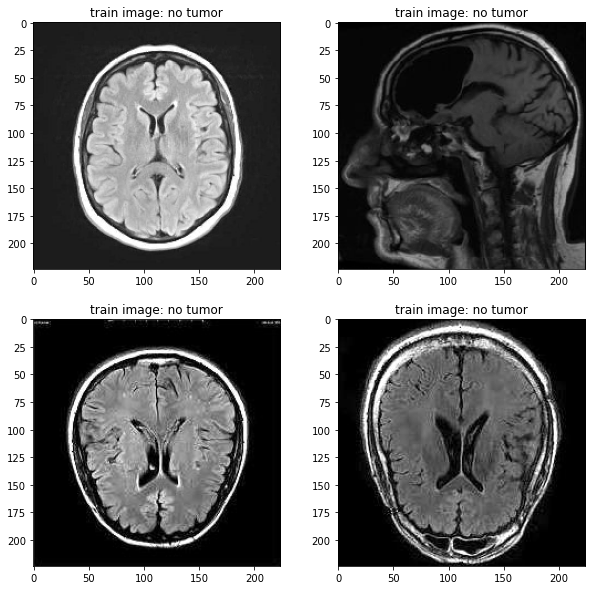

In [5]:
n_train_examples, n_test_examples = len(train_no_t), len(test_no_labels[0]) + len(test_yes_labels[0])
print(f"Number of training samples: {n_train_examples}; Number of test samples: {n_test_examples}")

# Plot some images from train and test sets
train_imgs = train_no_t[0:5]
test_imgs = test_no_labels[0][0:5]


plt.figure(figsize=(10, 10))
l =2
w = 2
for i in range(l*w):
    plt.subplot(l, w, i+1)
    plt.grid(False)
    plt.imshow(train_imgs[i], cmap='gray')
    plt.axis('on')
    plt.title("train image: no tumor")

plt.show()

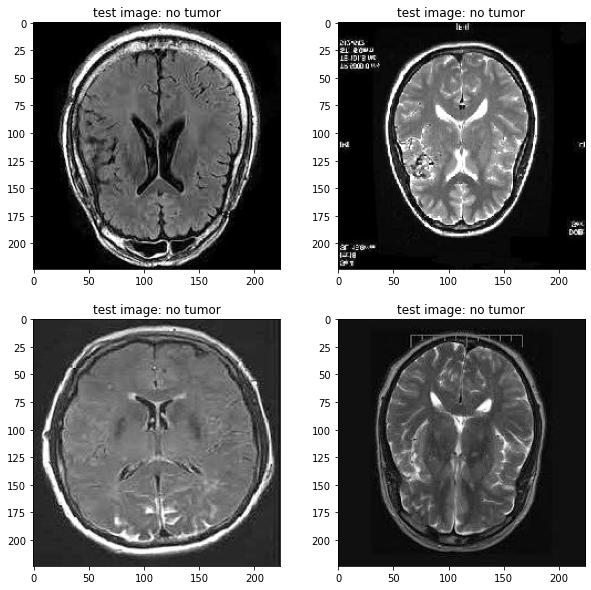

In [9]:
plt.figure(figsize=(10, 10))
l =2
w = 2
for i in range(l*w):
    plt.subplot(l, w, i+1)
    plt.grid(False)
    plt.imshow(test_imgs[i], cmap='gray')
    plt.axis('on')
    plt.title("test image: no tumor")

plt.show()

# Preprocessing

- Standardization: scale pixel values to have 0 mean and unit variance
- Randomized SVD: perform image reconstruction by approximating lower dimensional representations of each image
- Non-negative Matrix Factorization (NMF): decompose the data matrix as $$ X \in \mathbb{R}^{mxn} \approx W \in \mathbb{R}^{mxr} H \in \mathbb{R}^{rxn}$$

In [6]:
def standardize(images):
    '''Accepts image list/array of shape: n x height*width'''
    standardized_images = []
    
    for img in images:
        stand_img = (img - np.mean(img, axis=0)) / np.std(img, axis=0)
        standardized_images.append(stand_img)
    return standardized_images

In [7]:
train_data = np.array(train_no_t)
train_data = np.reshape(train_data, newshape=(train_data.shape[0], train_data.shape[1]*train_data.shape[2]))
train_data_stand = standardize(train_data)

# Randomized SVD

In [8]:
# SVD vs randSVD for 1 image
A = train_data_stand[320].reshape((224, 224))

# regular svd
start = time.time()
U1, S1, V1 = svd(A)
end = time.time()
print('Reg SVD: ', end-start)

# randomized svd
start = time.time()
U2, S2, V2 = randomized_svd(A, n_components=30, random_state=0)
end = time.time()
print('Rnd SVD: ', end-start)

Reg SVD:  0.03203392028808594
Rnd SVD:  0.022706985473632812


In [ ]:
# function that reconstructs images using randomized svd
def randSVD_recon(A, k, graph=False):
    U, S, V = randomized_svd(A, n_components=k, random_state=0)
    recon = np.dot(U[:,:k], V[:k,:] * S[:k].reshape(k,1))
    
    if (graph):
        _, ax = plt.subplots(1, 2, figsize=(10,6))
        
        ax[0].imshow(A, cmap='gray')
        ax[0].axis('off')
        ax[0].set_title('Original image')
        
        ax[1].imshow(recon, cmap='gray')
        ax[1].axis('off')
        ax[1].set_title(f'Compressed image with rank {k}')
    
        plt.show()
    
    return recon


# NMF image reconstruction
def nmf_recon(img):
    '''Accepts an img shape: 224 x 224'''
    
    nmf = NMF(n_components=35, init='random', verbose=1, max_iter=500)
    W = nmf.fit_transform(img.reshape((224, 224)))
    H = nmf.components_
    
    img_recon = np.dot(W, H)
    
    return img_recon

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


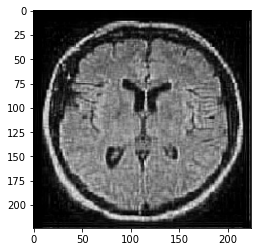

In [12]:
# Perform NMF decomposition on the non-standardized images 

nmf_recon = nmf_recon(train_data[320].reshape((224, 224)))
plt.imshow(nmf_recon, cmap='gray')
plt.show()

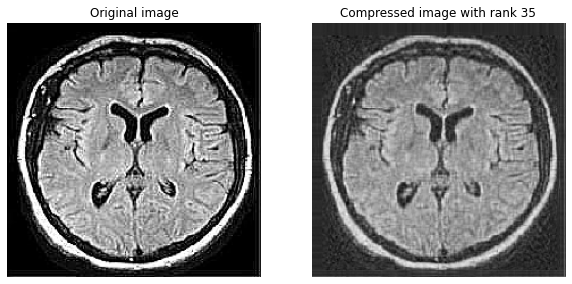

In [10]:
reconstructed_img = randSVD_recon(train_data_stand[320].reshape((224, 224)), k=35, graph=True)

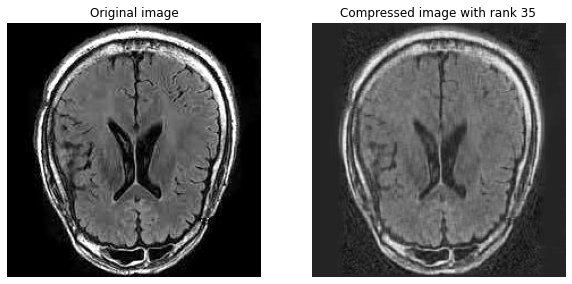

In [11]:
_ = randSVD_recon(test_imgs[0], k=35, graph=True)

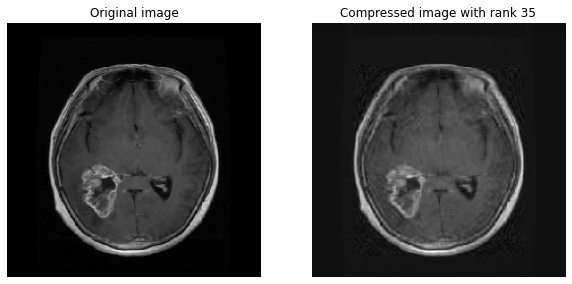

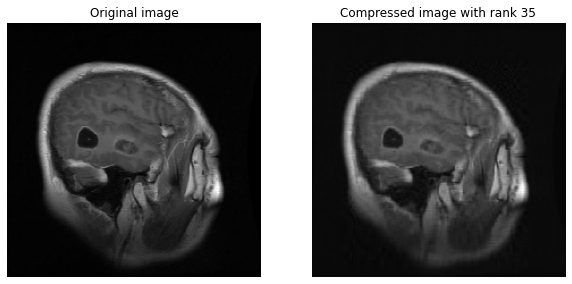

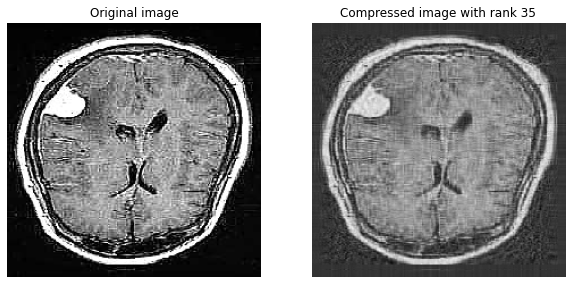

randSVD on training set: 27.992671966552734


In [12]:
# running reconstructor on all training images
graph_cond = True
start = time.time()
for i in range(len(train_data_stand)):
    _ = randSVD_recon(train_data_stand[i].reshape((224, 224)), k=35, graph=graph_cond)
    
    if i==2: graph_cond = False
end = time.time()
print('randSVD on training set:', end-start)

# Baseline anomaly detection model: PCA
- Compare original mri scans to scans represented in a new subspace
- Here, the "normal" mri scans are considered the anomalies. We wish to pass a dataset with a small percentage of anomalies with the hope of the model detecting salient features of tumorous brains -> distinguish these from normal brains
- Evaluate the comparisons using mean squared error
- The larger the error, the more likely the given image is an anomaly

## Revisiting the mathematics of PCA

- Data Matrix: $$ X \in \mathbb{R}^{mxn}  $$
$$ m = # of images. n = # of pixels (vectorized: height x width). $$


- SVD based PCA (performed on column centered data matrix): $$ \tilde{X} $$ 

- Decompose $$ \tilde{X} $$ as : $$ \tilde{X^T}\tilde{X} = {(U{\Sigma}{V^T})^T}(U{\Sigma}{V^T}) $$
$$ = V{\Sigma^2}V^T $$

- Introduce $${a_k} $$ as eigenvectors in new space such that $$ var(X{a_k}) = \lambda_k. $$

- The linear combinations: $$ X{a_k} $$ = Principal Components. 


- Taking $$ (\tilde{X} - X{a_k})^2 / n $$ gives "anomaly" scores

In [17]:
def pca_anomaly_detection(X):
    '''PCA Anomaly Detection model pipeline'''
    
    X_df = pd.DataFrame(X)

    pca_model = PCA(n_components=2)  # 2 components has better results compared to 4
    # train the PCA model
    pca_model.fit(X_df)
    
    pca_subspace = pca_model.fit_transform(X_df)
    
    # space of images of original dimension (num features != pca components)
    inverse_subspace = pca_model.inverse_transform(pca_subspace)
    
    # computing mean squared errors between original images and pca constructed images
    mse_scores = ((X_df - inverse_subspace)**2).sum(axis=1)
    
    return mse_scores, X_df, pca_model

## Build a training pipeline where we apply transformations to images before feeding to PCA model

In [34]:
def run_training(pca_tumor_images, pca_no_tumors_images, standardize_func, randSVD_func, nmf_decomp,
                 img_decomposition: str, plot_mse=False):
    
    torch.manual_seed(42)
    
    pca_imgs = pca_tumor_images + pca_no_tumors_images
    pca_arrays = np.array(pca_imgs)
    pca_arrays = pca_arrays.reshape((pca_arrays.shape[0], pca_arrays.shape[1]*pca_arrays.shape[2]))
    
    
    # Creating randSVD reconstructions or nmf reconstructions of images
    pca_recons = []
    
    if img_decomposition == "randSVD":
        
        pca_stand = standardize_func(pca_arrays)
        pca_stand_arrays = np.array(pca_stand)
        pca_tensor = torch.from_numpy(pca_stand_arrays)

        # Random permutation of rows (shuffle the images)
        pca_stand_shuffled = pca_tensor[torch.randperm(pca_tensor.size()[0])]
        pca_stand_shuffled = np.array(pca_stand_shuffled)
    
        for arr in pca_stand_shuffled:
            pca_arr_svd = randSVD_func(arr.reshape((224, 224)), k=35, graph=False)
            pca_recons.append(pca_arr_svd)
        pca_recon_arrays = np.array(pca_recons)
        
    else:
        # Perform NMF decomposition
        pca_tensors = torch.from_numpy(pca_arrays)
        pca_tensors_shuffled = pca_tensors[torch.randperm(pca_tensors.size()[0])]
        pca_tensors_shuffled = np.array(pca_tensors_shuffled)
        
        for arr in pca_tensors_shuffled:
            pca_arr_nmf = nmf_decomp(arr.reshape((224, 224)))
            pca_recons.append(pca_arr_nmf)
        pca_recon_arrays = np.array(pca_recons)
        
    
    pca_recon_arrays = pca_recon_arrays.reshape((pca_recon_arrays.shape[0], pca_recon_arrays.shape[1]*pca_recon_arrays.shape[2]))
    
    # Perform PCA
    start_pca = time.time()
    scores, pca_df, pca = pca_anomaly_detection(pca_recon_arrays)
    end_pca_time = time.time() - start_pca
    
    print(f"Time to run PCA on randSVDs reconstructions: {end_pca_time}")
    print('\n')
    print(f"9 largest MSE scores after PCA: {scores.nlargest(9)}")
    
    if plot_mse is True:
        scores.plot(figsize=(12, 6), title="MSE train scores on {} processed images".format(img_decomposition),
                    xlabel="Number of Samples", ylabel="Mean Squared Error (MSE)", kind='line', fontsize=14)
        
    plt.show()
    
    return pca, pca_df, scores

Time to run PCA on randSVDs reconstructions: 4.779011011123657


9 largest MSE scores after PCA: 924     65370.092526
552     52597.210534
563     52597.210534
438     52547.415812
919     48818.941691
128     48655.528286
175     48642.949224
1036    47701.724785
926     46675.723010
dtype: float64


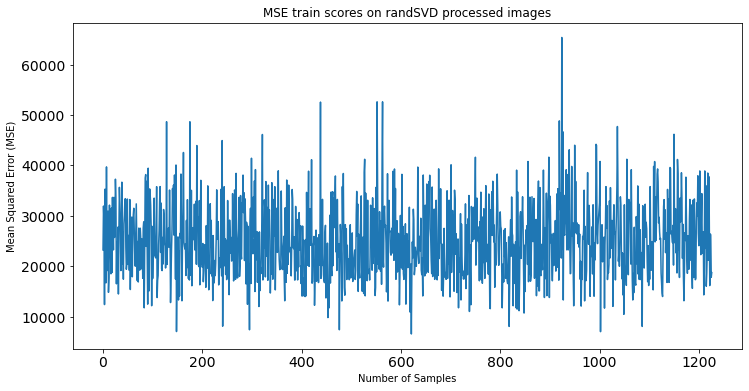

In [19]:
# Load the dataset containing tumor and non-tumor images

_, _, _, _, pca_t, pca_no_t = load_images(pca_path, "PCAdataset")

pca_MODEL, pca_DF, mse_train_scores_randSVD = run_training(pca_t, pca_no_t, standardize, randSVD_recon, nmf_recon,
                                                   "randSVD", plot_mse=True)

## Plot the 9 images correspond to the largest MSE scores (randSVD) -> large scores indicate anomalous images

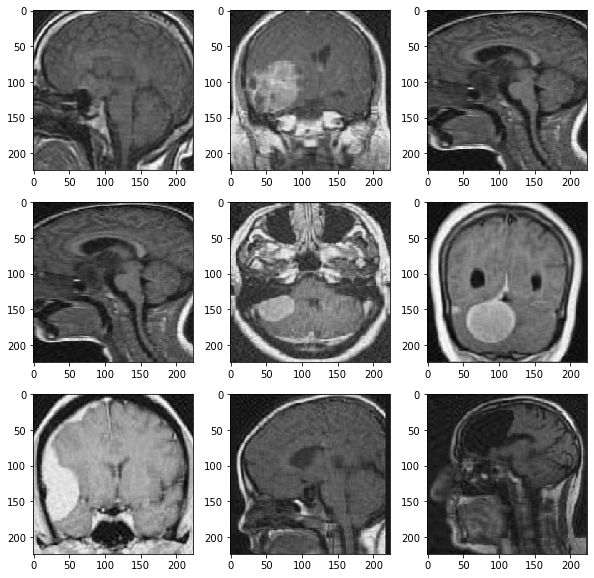

In [25]:
largest_mse_scores = mse_train_scores_randSVD.nlargest(9).index

plt.figure(figsize=(10, 10))
row, cols = 3, 3

for i in range(9):
    plt.subplot(row, cols, i+1)
    plt.imshow(pca_DF.iloc[largest_mse_scores[i]].values.reshape((224, 224)), interpolation='nearest', cmap='gray')
    plt.grid(False)
plt.show()

### Train on NMF processed images

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

Time to run PCA on randSVDs reconstructions: 5.476447105407715


9 largest MSE scores after PCA: 919     5217.176386
656     4628.419275
128     4558.661245
794     3996.318038
438     3948.901529
562     3927.254154
777     3876.255654
134     3795.388021
1110    3793.399835
dtype: float64


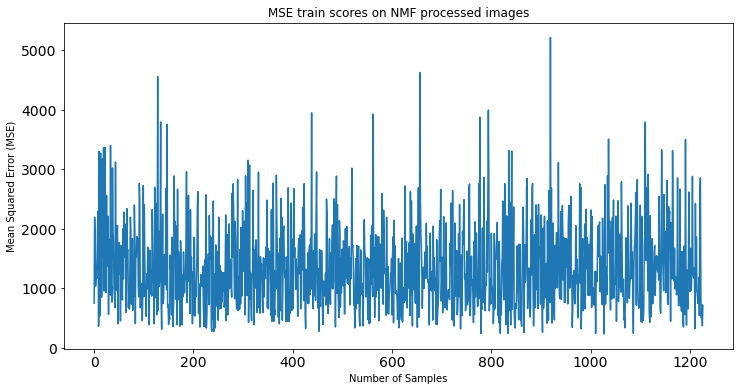

In [35]:
pca_MODEL, pca_DF, mse_train_scores_nmf = run_training(pca_t, pca_no_t, standardize, randSVD_recon, nmf_recon,
                                                   "NMF", plot_mse=True)

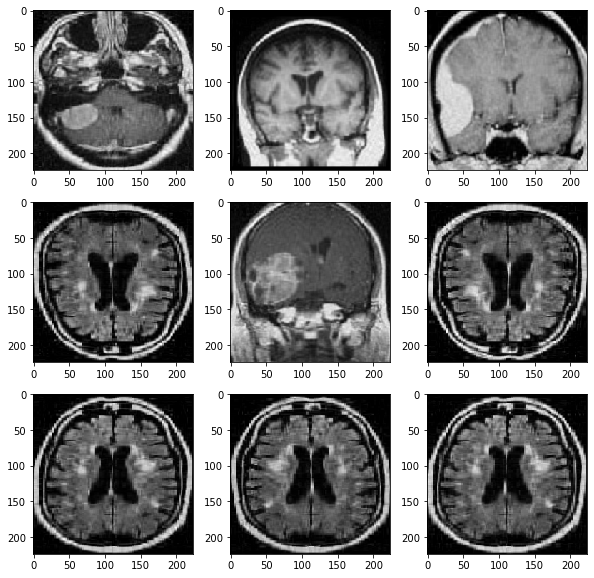

In [36]:
largest_mse_scores = mse_train_scores_nmf.nlargest(9).index

plt.figure(figsize=(10, 10))
row, cols = 3, 3

for i in range(9):
    plt.subplot(row, cols, i+1)
    plt.imshow(pca_DF.iloc[largest_mse_scores[i]].values.reshape((224, 224)), interpolation='nearest', cmap='gray')
    plt.grid(False)
plt.show()

## Evaluate the PCA model on the test set and visualize the MRI scans that PCA determined are anomalous

In [27]:
def run_evaluation(pca_model, test_no_tumor, test_tumor, standard_scaler, randSVD_transform, nmf_decomp,
                   img_decomposition: str, plot_mse=False):
    '''Here, we create a pipeline of transformations to make to images in the test set
            and then pass the processed images to the PCA model for evaluation.'''
    
    
    torch.manual_seed(42)
    
    test_no_t, y_test_no_t = test_no_tumor  
    test_t, y_test_t = test_tumor
    
    # y_test_.. = labels that we discard 
    test_list = test_no_t + test_t
    y_test = np.array(y_test_no_t + y_test_t)
    
    test_array = np.array(test_list)
    test_array = np.reshape(test_array, newshape=(test_array.shape[0], test_array.shape[1]*test_array.shape[2]))
    
    
    # Create image reconstructions using randSVD algorithm or nmf decomposition
    test_reconstructions = []
    
    if img_decomposition == "NMF":
    
        # Shuffle the non-standardized images
        test_tensors = torch.from_numpy(test_array)
        test_tensor_shuffle = test_tensors[torch.randperm(test_tensors.size()[0])]
        test_arrays = test_tensor_shuffle.numpy()
        
        for test_img in test_arrays:
            test_recon = nmf_decomp(test_img)
            test_reconstructions.append(test_recon)
        
    else:
            
        # Perform randSVD decomp on standardized images
        test_stand = standard_scaler(test_array)
        test_array_stand = np.array(test_stand)
        test_tensor_stand = torch.from_numpy(test_array_stand)

        # Shuffle the standardized images 
        test_shuffle_stand = test_tensor_stand[torch.randperm(test_tensor_stand.size()[0])]
        test_stand_arrays = test_shuffle_stand.numpy()
    
        for test_img in test_stand_arrays:
            test_recon = randSVD_transform(test_img.reshape((224, 224)), k=28, graph=False)
            test_reconstructions.append(test_recon)
    
    
    test_recons = np.array(test_reconstructions)
    test_data = np.reshape(test_recons, newshape=(test_recons.shape[0], test_recons.shape[1]*test_recons.shape[2]))
    test_df = pd.DataFrame(test_data)
    
    
    # Run PCA on test set
    test_pca_res = pca_model.transform(test_df)
    test_inverse_subspace = pca_model.inverse_transform(test_pca_res)
    
    test_eval_scores = ((test_df - test_inverse_subspace)**2).sum(axis=1)
    
    
    # Visualize mse scores on test images
    if plot_mse is True:
        test_eval_scores.plot(figsize=(12, 6), title="MSE Test scores on {} processed images".format(img_decomposition), 
        xlabel="Number of Samples", ylabel="Mean Squared Error (MSE)", kind='line', fontsize=14, colormap='autumn')
        
    plt.show()
    
    return test_eval_scores, test_df

### NMF preprocessing results on Test data

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/

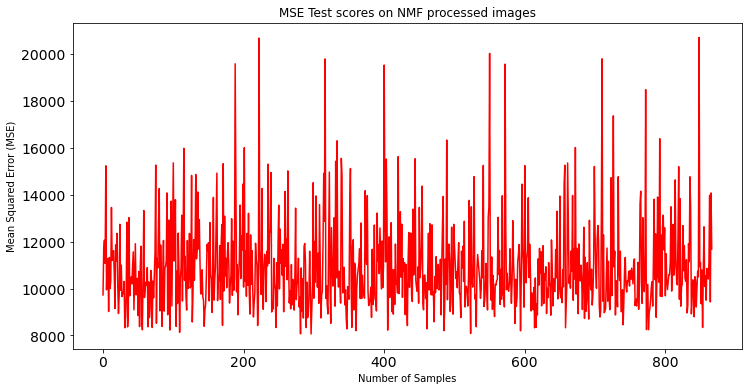

In [29]:
test_mse_scores, test_df = run_evaluation(pca_MODEL, test_no_labels, test_yes_labels, standardize, randSVD_recon, 
                                          nmf_recon, "NMF", plot_mse=True)

## Plot the test images (NMF) with the highest MSE scores

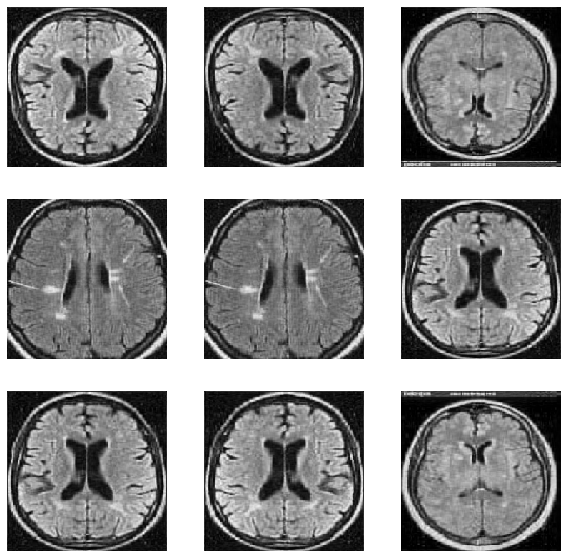

In [30]:
largest_test_mse = test_mse_scores.nlargest(9).index

plt.figure(figsize=(10, 10))
row, col = 3, 3

for i in range(9):
    plt.subplot(row, col, i+1)
    plt.imshow(test_df.iloc[largest_test_mse[i]].values.reshape((224, 224)), interpolation='nearest', cmap='gray')
    plt.axis('off')
plt.show()

### randSVD preprocessing done on Test set

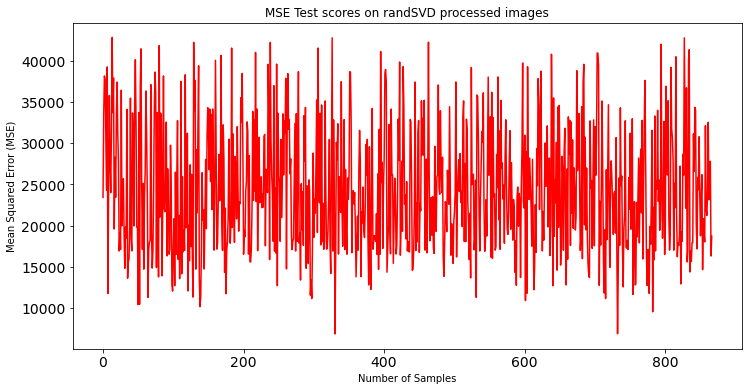

In [31]:
test_mse_scores, test_df = run_evaluation(pca_MODEL, test_no_labels, test_yes_labels, standardize, randSVD_recon, 
                                          nmf_recon, "randSVD", plot_mse=True)

## Plot the test images (randSVD) with the highest MSE scores

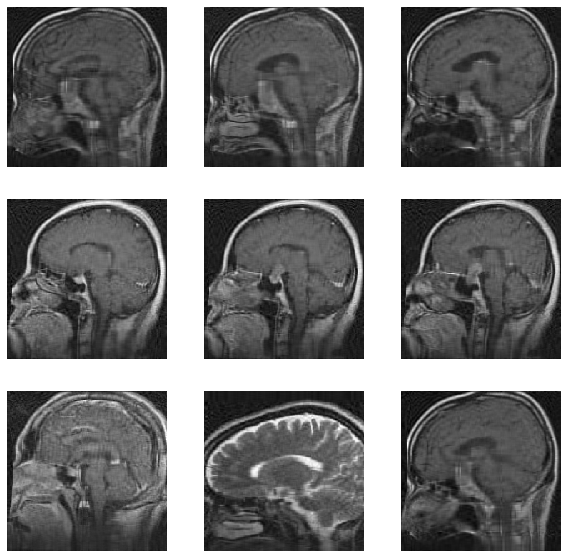

In [32]:
largest_test_mse = test_mse_scores.nlargest(9).index

plt.figure(figsize=(10, 10))
row, col = 3, 3

for i in range(9):
    plt.subplot(row, col, i+1)
    plt.imshow(test_df.iloc[largest_test_mse[i]].values.reshape((224, 224)), interpolation='nearest', cmap='gray')
    plt.axis('off')
plt.show()